# **Assignment 2: Sentiment Analysis** 
<br>
Author: Stephanie Anagnostou 
<br>
University of Toronto, Faculty of Engineering
<br>
March 26, 2020

### [Data Cleaning](#Data-Cleaning)
<br>

### [Exploratory Data Analysis](#Exploratory-Data-Analysis)
<br>

[Determine the political party](#Determine-the-political-party)
<br>

[Plot the graphs](#Plot-the-graphs)
<br>

### [Model Preparation](#Model-Preparation)
<br>

[Prepare the training and test data](#Prepare-the-training-and-test-data)
<br>

[TFID and Frequency](#TFID-and-Frequency)
<br>

[Best Model and Vectorizer](#Best-Model-and-Vectorizer)
<br>

### [Tune Model Parameters](#Tune-Model-Parameters)
<br>

[Parameter Tuning](#Parameter-Tuning)
<br>

### [Results](#Tune-Model-Parameters)
<br>

[Party Identification](#Party-Identification)
<br>

[Sentiment Prediction](#Sentiment-Prediction)
<br>

[Negative Reason Prediction](#Negative-Reason-Prediction)
<br>

[Party percentages prediction](#Party-percentages-prediction)

In [3]:
!pip install nltk

In [4]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
try:
 #   from gensim.models import word2vec
except:
    !pip install gensim
    from gensim.models import word2vec


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from html.parser import HTMLParser
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import itertools    
%matplotlib inline

## Data Cleaning

After making the necessary imports, the next step is to process the tweets - this will be accomplished through the following procedure: 
1. Transform all tweets to lowercase
2. Remove the string value "b" at the beginning of each tweet
3. Remove all HTML tags 
4. HTLM unencoding 
5. Remove hyperlinks (i.e. http and https)
6. Remove the stop words

For step 6, I will use the stop words provided from the file. 

In [7]:
with open('stop_words.txt', 'r') as f:
    stopwords = f.readlines()
stopwords=[line[:-1] for line in stopwords]

The code below shows the function for cleaning the tweets:

In [8]:
def cleanupTweet(tweet):
    hparser         = HTMLParser()
    line            = tweet
    processed_tweet = line.lower() # lowercase    
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    processed_tweet = re.sub(r'^b\"', '',processed_tweet )
    processed_tweet = re.sub(r'<[^>]+>', '',processed_tweet )
    processed_tweet = hparser.unescape(processed_tweet)
    processed_tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', processed_tweet, flags=re.MULTILINE)
    processed_tweet = ' '.join([word for word in processed_tweet.split() if word not in stopwords])
    return processed_tweet

In the code below, I define a pandas dataframe for each csv file and add the new columns with the cleaned up tweets. Then I apply the function above to the text column and store the result in a new column called processed_tweet. 

In [9]:
CAN_election = pd.read_csv('Canadian_elections_2019.csv')
sentiment_df = pd.read_csv('Sentiment.csv')

In [10]:
CAN_election['processed_tweet'] = CAN_election.apply(lambda row: cleanupTweet(str(row.text)), axis = 1)
sentiment_df['processed_tweet'] = sentiment_df.apply(lambda row: cleanupTweet(str(row.text)), axis = 1)

## Exploratory Data Analysis

### Determine the political party

The next step is to find the political affiliation of each tweet. I will following the following procedure to complete this task: 
1. Add 4 new columns, one for each political party plus 'None'. '
2. Process each tweet 
3. Analyze the results and determine if I can specify the political party using certain keywords

<br>
Reasoning: For this section I chose to use multiple fields because a tweet may be affiliated to 2 or 3 parties. Consequently, I will find all the parties that are affiliated with a tweet. 
<br>
<br>
The function 'add_parties_to_dataframe' takes as parameter a data frame and adds 4 columns - one column for each party plus None. It processes the column 'processed_tweet' and populates the party columns based on the affiliation and the sentiment. For example, if the tweet is affiliated with the Liberals then it will put True or False on the Liberal column depending on the sentiment. Therefore, it is possible a single tweet to be affiliated with more than one parties.

In [11]:
def add_parties_to_dataframe (DF):
    DF['Conservative'] = ''
    DF['Liberal'] = ''
    DF['NDP'] = ''
    DF['None'] = ''
    for row in DF.index: 
        if re.match ('.*justin.*|.*trudeau.*|.*justintrudeau.*|.*liberal.*', DF['processed_tweet'][row]) :
            if DF['sentiment'][row]== 'Positive':
                DF["Liberal"][row] = 'True'
            else :
                DF["Liberal"][row] = 'False'
        if re.match ('.*andrew.*|.*scheer.*|.*andrewscheer.*|.*conservative.*', DF['processed_tweet'][row]) :
            if DF['sentiment'][row]== 'Positive':
                DF["Conservative"][row] = 'True'
            else :
                DF["Conservative"][row] = 'False'        
        if re.match ('.*jagmeet.*|.*singh.*|.*jagmeetsingh.*|.*[^a-z]ndp[^a-z].*', DF['processed_tweet'][row]) :
            if DF['sentiment'][row]== 'Positive':
                DF["NDP"][row] = 'True'
            else :
                DF["NDP"][row] = 'False'
        if DF["Liberal"][row] == '' and DF["Conservative"][row] == '' and DF["NDP"][row] == '':
            if DF['sentiment'][row]== 'Positive':
                DF["None"][row] = 'True'
            else :
                DF["None"][row] = 'False'


In the code below, I will apply the function 'add_parties_to_dataframe' to each dataframe:

In [12]:
add_parties_to_dataframe(CAN_election)
add_parties_to_dataframe(sentiment_df)

In [13]:
print('NDP Positive tweets: ' + str(CAN_election[CAN_election['NDP'] == 'True'].shape[0]))
print('NDP Negative tweets: ' + str(CAN_election[CAN_election['NDP'] == 'False'].shape[0]))
print('Conservative Positive tweets: ' + str(CAN_election[CAN_election['Conservative'] == 'True'].shape[0]))
print('Conservative Negative tweets: ' + str(CAN_election[CAN_election['Conservative'] == 'False'].shape[0]))
print('Liberal Positive tweets: ' + str(CAN_election[CAN_election['Liberal'] == 'True'].shape[0]))
print('Liberal Negative tweets: ' + str(CAN_election[CAN_election['Liberal'] == 'False'].shape[0]))

NDP Positive tweets: 137
NDP Negative tweets: 80
Conservative Positive tweets: 190
Conservative Negative tweets: 379
Liberal Positive tweets: 242
Liberal Negative tweets: 288


Based on the information above, I can interpolate that the total number of tweets for each party approximately represents the same ratio as the election percentages. For example, the ratio of tweets between NDP and Conservatives is about 1 to 2 which is about the same as the percentage ratio as in the election 16 to 34.5. Moreover, the ratio of Positive to Negative tweets is much different  between parties. For example, for NDP the Positive tweets is significantly higher than the Negative ones but for the Conservative party its the opposite. Furthermore, the Liberals tweets are more balanced. One possible improvement is if the analysis had included more tweets to find a larger number key words. 

### Plot the graphs

[Text(0, 0, 'Positive'), Text(0, 0, 'Negative'), Text(0, 0, 'Neutral')]

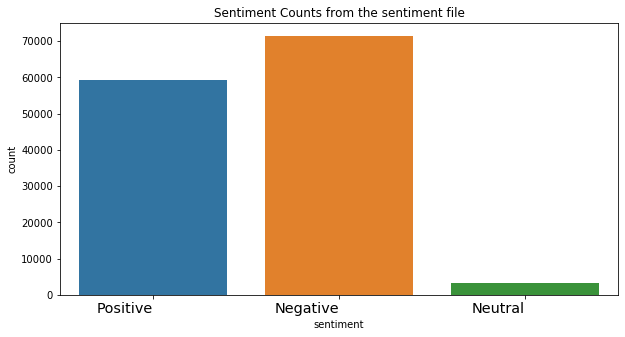

In [20]:
plt.figure(figsize=(10,5))
chart = sns.countplot(x='sentiment', data = sentiment_df)
chart.set_title('Sentiment Counts from the sentiment file')
chart.set_xticklabels(chart.get_xticklabels(),  horizontalalignment='right', fontweight='light', fontsize='x-large')


Text(0.5, 1.0, 'Negative Reason Counts from the Canadian Elections file')

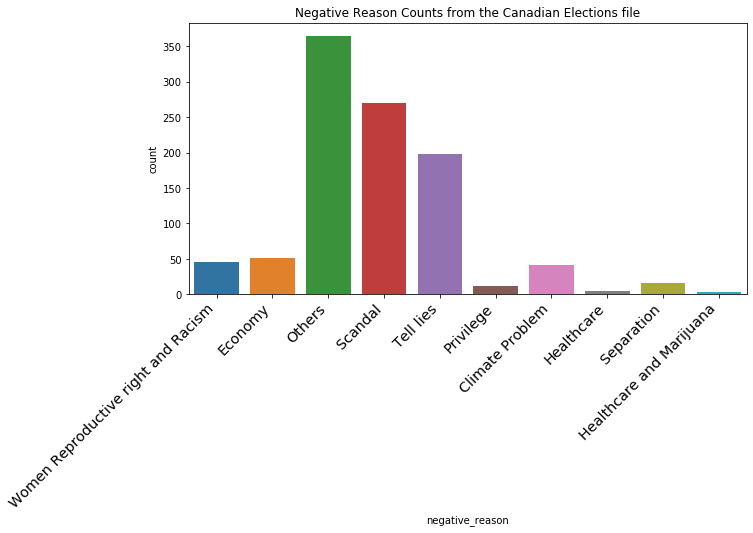

In [23]:
plt.figure(figsize=(10,5))
chart = sns.countplot(x='negative_reason',  data = CAN_election)
chart.set_xticklabels(chart.get_xticklabels(),  rotation=45, horizontalalignment='right', fontweight='light', fontsize='x-large')
chart.set_title('Negative Reason Counts from the Canadian Elections file')

## Model Preparation

### Prepare the training and test data

For the training data I will use 70% of the data and for the testing I will use 30%. The splitting of the target value and the training and test data is performed in the code below:

In [14]:
y = sentiment_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(sentiment_df['processed_tweet'], y, random_state=0, test_size=0.3)

### TFID and Frequency

Next I will create two variables using the TFID and Frequency.

In [15]:
TFIDVectorizer  = TfidfVectorizer(stop_words=stopwords, max_features=2000, min_df = 5, max_df = 0.8)
countVectorizer = CountVectorizer(stop_words=stopwords, max_features=2000, min_df = 5, max_df = 0.8)

Then I will create two lists: One with the classifiers and one with the vectorizers

In [16]:
listOfClassifiers = [LinearSVC(max_iter=1000000), MultinomialNB(), RandomForestClassifier(), KNeighborsClassifier(n_neighbors = 5),
                    KNeighborsClassifier(n_neighbors = 10), KNeighborsClassifier(n_neighbors = 30),
                    tree.DecisionTreeClassifier(),  GradientBoostingClassifier(), LogisticRegression(max_iter=1000000)]
listOfVectorizers = [TFIDVectorizer, countVectorizer]

Next, I will run the classification with both tokenizers (TFID and Frequency) and all the classifiers. I will measure the accuracy on the unseen test data. Another approach that could have been exercised is measuring the accuracy in all data, i.e., training and testing. 

In [ ]:
best_accuracy = 0 

for vectorizer in   listOfVectorizers:  
    print (vectorizer)
    
    ## convert each input tweet into a numerical vector  to be used in the classification  
    train_corpus_ = vectorizer.fit_transform(X_train)
    test_corpus_  = vectorizer.transform(X_test)
    
    ## loop through the classifiers
    for classifier in listOfClassifiers:
        print(classifier)

        model      =  classifier
        
        ## fit the model with the training data
        model.fit(train_corpus_,y_train)
        
        ## test the accuracy of the model with the test data
        result     = model.predict(test_corpus_)
        confMatrix = confusion_matrix(y_test, result)
        total      = sum(y_test == result)
        
        accuracy = round (100*total/y_test.shape[0], 2)
        print ('\t Accuracy : ' +  str (accuracy) + '%')
        if accuracy > best_accuracy:
            best_accuracy   = accuracy
            best_classifier = model
            best_vectorizer = vectorizer        

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=2000, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', '..., 'you', 'youd', "you'll", 'your', 'youre', 'yours', 'yourself', 'yourselves', "you've", 'z', 'zer'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000000,
     multi_class='ovr', 

### Best Model and Vectorizer

In [17]:
print (' Best Accuracy: ' +  str (best_accuracy) + '%')
print (' Best Model: ' + str(best_classifier))
print (' Best Vectorizer: '  + str(best_vectorizer))

 Best Accuracy: 71.3%
 Best Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
 Best Vectorizer: TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=2000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'able', 'about', 'above', 'abst', 'accordance',
                            'according', 'accordingly', 'across', 'act',
                            'actually', 'added', 'adj', 'affected', 'affecting',
                            'affects', 'after', 'afterward

## Tune Model Parameters 

Next, I trained the models with 70% of tweets and tested the accuracy on the 30% test data. The accuracy of the best classifier was around 71% for the Logistic Regression with the TFID vectorizer, which was the best model. 

### Parameter Tuning 

The parameter tuning was completed using the Grid Search with Cross Validation and using 3 folds to determine if I could improve the accuracy. 

In [37]:
train_corpus_ = best_vectorizer.fit_transform(X_train)
test_corpus_  = best_vectorizer.transform(X_test)
    
# Create the parameter grid for the logistic regression classifier
grid ={"C":[0.8, 0.9,1,1.1], "penalty":["l2"], "tol":[0.00001, 0.000015]}

# Use the grid to search for best hyperparameters
# First create the base model to tune
# Create a based model
rf =  LogisticRegression(max_iter=1000000)


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(train_corpus_,y_train)
print(grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   36.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   37.1s finished


{'C': 1.1, 'penalty': 'l2', 'tol': 1e-05}


Next I will calculate the accuracy on the training data with the best parameters found.

In [49]:
rf_best =  LogisticRegression(max_iter=1000000, C= 1.1, penalty = 'l2', tol=1e-05 )

rf_best.fit(train_corpus_,y_train)
result     = rf_best.predict(test_corpus_)
confMatrix = confusion_matrix(y_test, result)
total      = sum(y_test == result)
print ('\t Accuracy : ' +   str (round (100*total/y_test.shape[0], 2)) + '%')
print(confMatrix)

	 Accuracy : 71.31%
[[15476   146  5724]
 [  660   216   107]
 [ 4821    61 12933]]


From the results, the grid search improved the accuracy slightly. This is because previously I changed some of the parameters and because looped through a lot of classifiers. Consequently, the best classifier was already as good as it gets. Next, I will use this model next to test the accuracy on the Canadian Elections data.

In the code below I will check the previous model in the Canadian Elections file. For this, I will not re-train the model and I will use all the data for measuring accuracy since all the data is new to the model. This is because the model was trained in the sentiment file data.

In [20]:
y             = CAN_election['sentiment']
whole_corpus_ = best_vectorizer.transform(CAN_election['processed_tweet'])
result        = rf_best.predict(whole_corpus_)
confMatrix    = confusion_matrix(y, result)
total         = sum(y == result)
print ('\t Accuracy : ' +                str (round (100*total/y.shape[0], 2)) + '%')
#print(confMatrix)

	 Accuracy : 60.43%


As shown above, the accuracy of the model in the Canadian Elections is less than the sentiment file by about 11%. Intuitively, this makes sense because the Canadian Elections file data are completely new to the model. 

Next, I will check how the model behaves in the data for each party.

In [50]:
liberal_df      = CAN_election[(CAN_election['Liberal'] == 'True') | (CAN_election['Liberal'] == 'False') ][['sentiment', 'processed_tweet']]
NDP_df          = CAN_election[(CAN_election['NDP'] == 'True') | (CAN_election['NDP'] == 'False') ][['sentiment', 'processed_tweet']]
conservative_df = CAN_election[(CAN_election['Conservative'] == 'True') | (CAN_election['Conservative'] == 'False') ][['sentiment', 'processed_tweet']]

In [51]:
y = liberal_df['sentiment']
X = liberal_df['processed_tweet']
corpus_    = best_vectorizer.transform(X)
result     = rf_best.predict(corpus_)
confMatrix = confusion_matrix(y, result)
total      = sum(y == result)
print ('\t Accuracy for Liberal related tweets: ' +                str (round (100*total/y.shape[0], 2)) + '%')
print(confMatrix)


y = NDP_df['sentiment']
X = NDP_df['processed_tweet']
corpus_    = best_vectorizer.transform(X)
result     = rf_best.predict(corpus_)
confMatrix = confusion_matrix(y, result)
total      = sum(y == result)
print ('\t Accuracy for NDP related tweets: ' +                str (round (100*total/y.shape[0], 2)) + '%')
print(confMatrix)


y = conservative_df['sentiment']
X = conservative_df['processed_tweet']
corpus_    = best_vectorizer.transform(X)
result     = rf_best.predict(corpus_)
confMatrix = confusion_matrix(y, result)
total      = sum(y == result)
print ('\t Accuracy for related Conservative: ' +   str (round (100*total/y.shape[0], 2)) + '%')
print(confMatrix)

	 Accuracy for Liberal related tweets: 63.58%
[[182 106]
 [ 87 155]]
	 Accuracy for NDP related tweets: 65.44%
[[43 37]
 [38 99]]
	 Accuracy for related Conservative: 60.46%
[[235 144]
 [ 81 109]]


In the code below I will use the best model for predicting the sentiment from the tweets and I will use the keyword party affiliation matching to find the party of each tweet. 
<br>
<br>
Reasoning: Using this technique, I will be able to predict the party and whether each tweet is positive or negative sentiment. This program will be able to process a number of tweets and it will be able to calculate the percentage for each party. In other words, the program will predict party percentages based on tweets alone. 

To achieve this I will start by adding 3 columns in the sentiment file, one for each party. I will use the same regular expression matching which was used previously to determine which party each tweet refers to. Also, I will not use the stored sentiment and instead i will use the best classifier from above to predict the sentiment. 
<br>
<br>
One column will indicate the party the tweet relates to. The second column will predict the sentiment as either positive, negative or neutral. Then i will check if the percentage of the positive tweets match the election percentage. 

First, I will calculate the party.

In [56]:
sentiment_df['Liberal'] = 'NO'
sentiment_df['Conservative'] = 'NO'
sentiment_df['NDP'] = 'NO'
for row in sentiment_df.index: 
    if re.match ('.*justin.*|.*trudeau.*|.*justintrudeau.*|.*liberal.*', sentiment_df['processed_tweet'][row]) :
        sentiment_df['Liberal'][row] = 'YES'    
    if re.match ('.*andrew.*|.*scheer.*|.*andrewscheer.*|.*conservative.*', sentiment_df['processed_tweet'][row]) :
        sentiment_df['Conservative'][row] = 'YES'
    if re.match ('.*jagmeet.*|.*singh.*|.*jagmeetsingh.*|.*[^a-z]ndp[^a-z].*', sentiment_df['processed_tweet'][row]) :
        sentiment_df['NDP'][row]='YES'

In [58]:
#liberal election percent was 33%
election_df=sentiment_df[sentiment_df['Liberal'] == 'YES']
corpus = best_vectorizer.transform(election_df['processed_tweet'])
predicts=rf_best.predict(corpus)

liberal_percentage = round(100*np.sum (predicts=='Positive')/election_df.shape[0], 2)
print( 'Liberal percentage = ' + str(liberal_percentage))



# Conservative election percent was 34.5%
election_df=sentiment_df[sentiment_df['Conservative'] == 'YES']
corpus = best_vectorizer.transform(election_df['processed_tweet'])
predicts=rf_best.predict(corpus)

conservative_percentage = round(100*np.sum (predicts=='Positive')/election_df.shape[0], 2)
print( 'Conservative percentage = ' + str(conservative_percentage))



# NDP election percent was 16%
election_df=sentiment_df[sentiment_df['NDP'] == 'YES']
corpus = best_vectorizer.transform(election_df['processed_tweet'])
predicts=rf_best.predict(corpus)

ndp_percentage = round(100*np.sum (predicts=='Positive')/election_df.shape[0], 2)
print( 'NDP percentage = ' + str(ndp_percentage))

Liberal percentage = 38.28
Conservative percentage = 36.33
NDP percentage = 33.33


### Plot the percentages as predicted by my model

First, I will initialize a list of lists. Next, I will create the pandas dataframe and put the results into the dataframe. Finally, I will plot the results. 

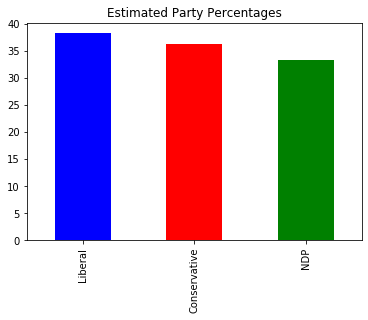

In [75]:
data = [['Liberal', liberal_percentage], ['Conservative', conservative_percentage], ['NDP', ndp_percentage]] 
  
df = pd.DataFrame(data, columns = ['Party', 'Percentage'],   index=['Liberal', 'Conservative', 'NDP'])
 
my_colors = ['b', 'r', 'g', 'y', 'k']
df['Percentage'].plot(kind='bar', color=my_colors,stacked=True, colormap='Paired',
                     lw=2,  title='Estimated Party Percentages')

###  Find the reason for the Negative tweets
For this section, I will use 2 vectorizers (i.e., TFID & frequency) and a list of classifiers. The difference between this approach and the previous approach is that I will measure the accuracy on all the data (training and testing).

In [21]:
neg_sent_df = CAN_election[CAN_election['sentiment'] == 'Negative'][['negative_reason', 'processed_tweet']]
y           = neg_sent_df['negative_reason']
X_train, X_test, y_train, y_test = train_test_split(neg_sent_df['processed_tweet'], y, random_state=0, test_size=0.3)
X = neg_sent_df['processed_tweet']

TFIDVectorizer  = TfidfVectorizer(stop_words=stopwords, max_features=2000, min_df = 5, max_df = 0.8)
countVectorizer = CountVectorizer(stop_words=stopwords, max_features=2000, min_df = 5, max_df = 0.8)

listOfClassifiers = [LinearSVC(max_iter=1000000), MultinomialNB(), RandomForestClassifier(), KNeighborsClassifier(n_neighbors = 5),
                    KNeighborsClassifier(n_neighbors = 10), KNeighborsClassifier(n_neighbors = 30),
                    tree.DecisionTreeClassifier(),  GradientBoostingClassifier(), LogisticRegression(max_iter=1000000)]
listOfVectorizers = [TFIDVectorizer, countVectorizer]

Next, I develop a function that plots the confusion matrix. 

In [22]:
def padd_plot_conf_matrix(conf_matrix, x_labels, y_labels):
    
    blank_array = [[-1 for i in range(len(y_labels))]]
    pad_conf_matrix = np.concatenate((blank_array, conf_matrix, blank_array ))
    
    plt.figure(figsize=[9,9]) # Change this as needed.
    plt.imshow(pad_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", color="blue")
    plt.xlabel('Predicted', color="blue")
    plt.ylabel('Actual', color="blue")
    plt.tight_layout()
    plt.colorbar()
    
    x_posits = np.arange(len(x_labels))
    y_posits = np.arange(len(y_labels)+2)
    plt.xticks(x_posits, x_labels, rotation=90)
    plt.yticks(y_posits, [""] + y_labels + [""])
    
    thresh = conf_matrix.max()/2.
    for i in range(1, len(y_labels)+1):
        for j in range(len(x_labels)):
            plt.text(j,i, pad_conf_matrix[i,j], fontsize=15, horizontalalignment="center",
                        color="white" if pad_conf_matrix[i,j]>thresh else "black")

    plt.show()

Next, I will run all my classifiers with both vectorizers and find out which model has the best accuracy. For this, I will measure the accuracy on all the data (testing and training).

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=2000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'able', 'about', 'above', 'abst', 'accordance',
                            'according', 'accordingly', 'across', 'act',
                            'actually', 'added', 'adj', 'affected', 'affecting',
                            'affects', 'after', 'afterwards', 'again',
                            'against', 'ah', 'all', 'almost', 'alone', 'along',
                            'already', 'also', 'although', 'always', 'am', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)
LinearSVC(C=1.0, class_weight=None, dua

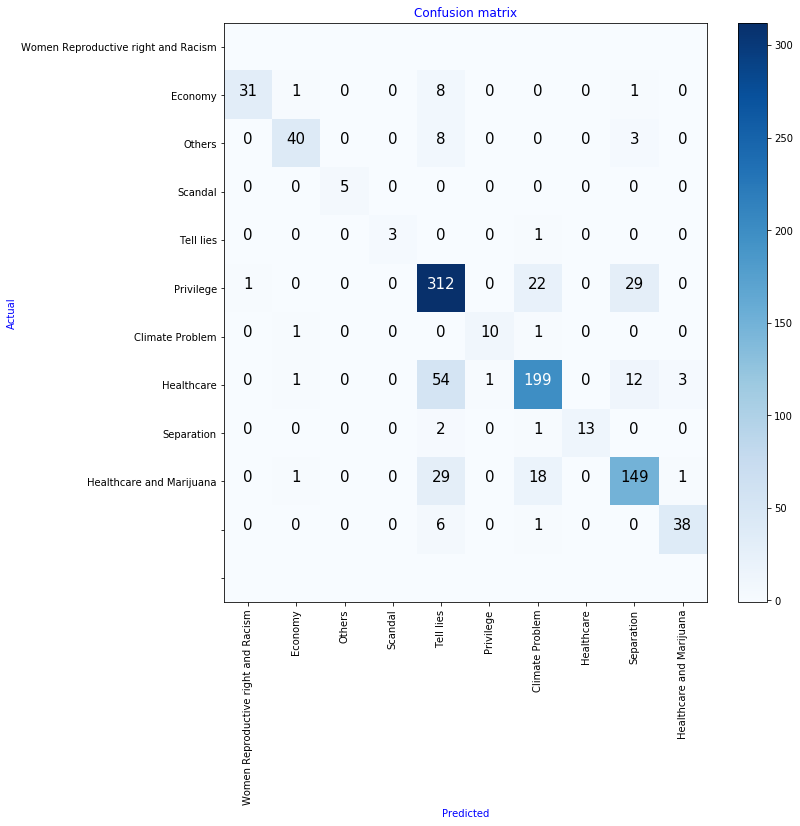

	 Accuracy : 79.52%
[[ 31   1   0   0   8   0   0   0   1   0]
 [  0  40   0   0   8   0   0   0   3   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   3   0   0   1   0   0   0]
 [  1   0   0   0 312   0  22   0  29   0]
 [  0   1   0   0   0  10   1   0   0   0]
 [  0   1   0   0  54   1 199   0  12   3]
 [  0   0   0   0   2   0   1  13   0   0]
 [  0   1   0   0  29   0  18   0 149   1]
 [  0   0   0   0   6   0   1   0   0  38]]
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


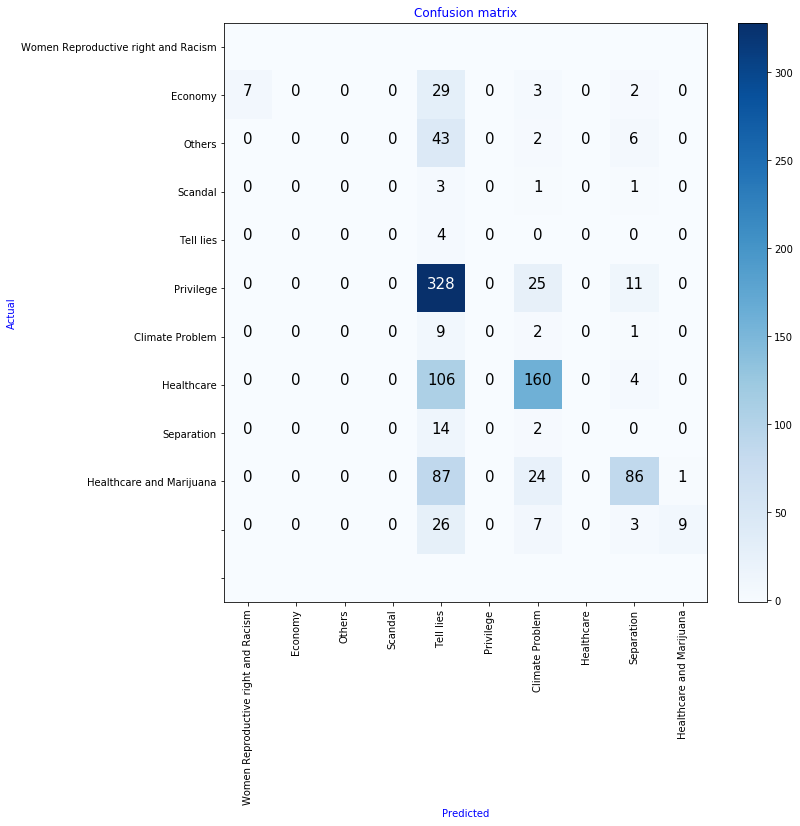

	 Accuracy : 58.65%
[[  7   0   0   0  29   0   3   0   2   0]
 [  0   0   0   0  43   0   2   0   6   0]
 [  0   0   0   0   3   0   1   0   1   0]
 [  0   0   0   0   4   0   0   0   0   0]
 [  0   0   0   0 328   0  25   0  11   0]
 [  0   0   0   0   9   0   2   0   1   0]
 [  0   0   0   0 106   0 160   0   4   0]
 [  0   0   0   0  14   0   2   0   0   0]
 [  0   0   0   0  87   0  24   0  86   1]
 [  0   0   0   0  26   0   7   0   3   9]]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


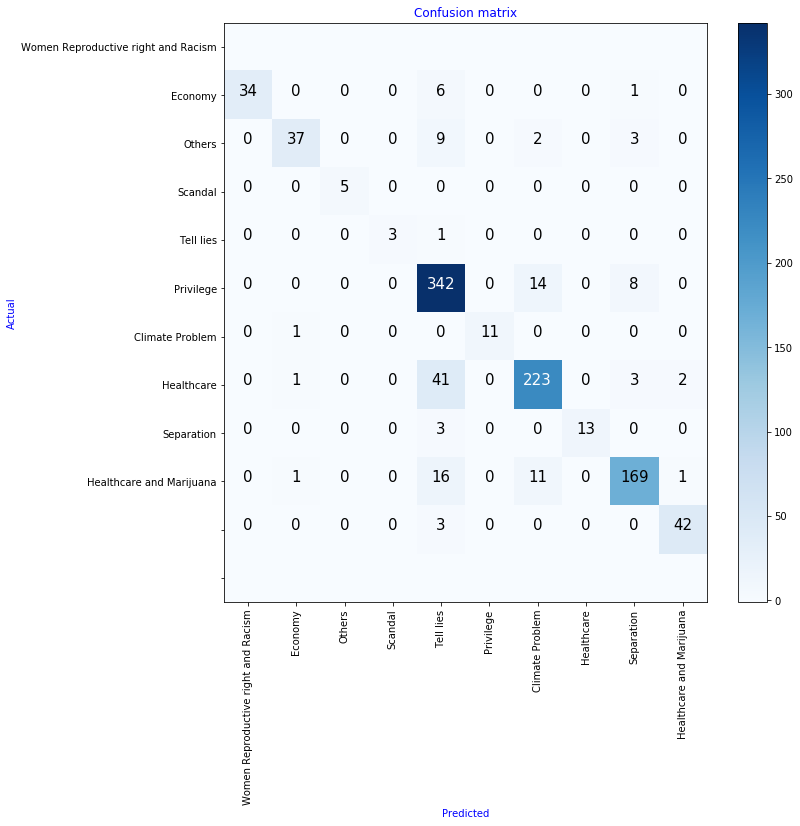

	 Accuracy : 87.38%
[[ 34   0   0   0   6   0   0   0   1   0]
 [  0  37   0   0   9   0   2   0   3   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   3   1   0   0   0   0   0]
 [  0   0   0   0 342   0  14   0   8   0]
 [  0   1   0   0   0  11   0   0   0   0]
 [  0   1   0   0  41   0 223   0   3   2]
 [  0   0   0   0   3   0   0  13   0   0]
 [  0   1   0   0  16   0  11   0 169   1]
 [  0   0   0   0   3   0   0   0   0  42]]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


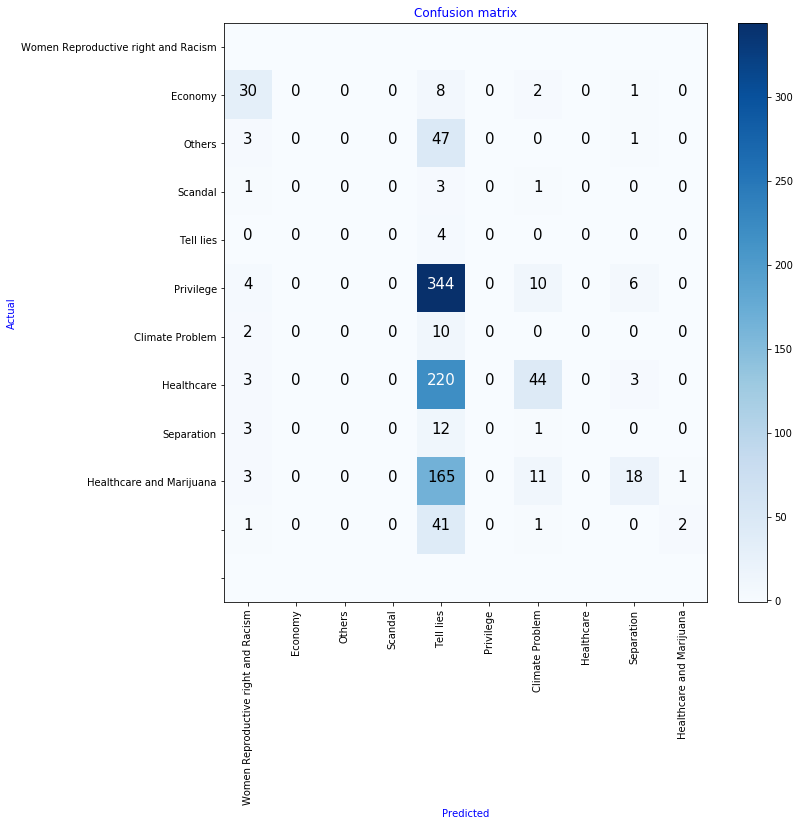

	 Accuracy : 43.54%
[[ 30   0   0   0   8   0   2   0   1   0]
 [  3   0   0   0  47   0   0   0   1   0]
 [  1   0   0   0   3   0   1   0   0   0]
 [  0   0   0   0   4   0   0   0   0   0]
 [  4   0   0   0 344   0  10   0   6   0]
 [  2   0   0   0  10   0   0   0   0   0]
 [  3   0   0   0 220   0  44   0   3   0]
 [  3   0   0   0  12   0   1   0   0   0]
 [  3   0   0   0 165   0  11   0  18   1]
 [  1   0   0   0  41   0   1   0   0   2]]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')


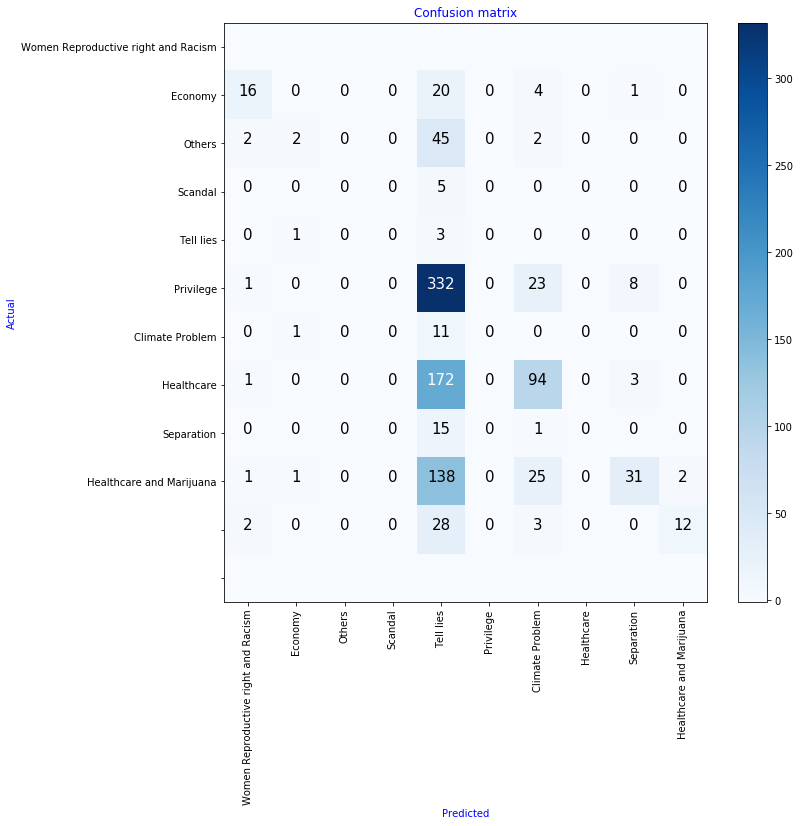

	 Accuracy : 48.41%
[[ 16   0   0   0  20   0   4   0   1   0]
 [  2   2   0   0  45   0   2   0   0   0]
 [  0   0   0   0   5   0   0   0   0   0]
 [  0   1   0   0   3   0   0   0   0   0]
 [  1   0   0   0 332   0  23   0   8   0]
 [  0   1   0   0  11   0   0   0   0   0]
 [  1   0   0   0 172   0  94   0   3   0]
 [  0   0   0   0  15   0   1   0   0   0]
 [  1   1   0   0 138   0  25   0  31   2]
 [  2   0   0   0  28   0   3   0   0  12]]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')


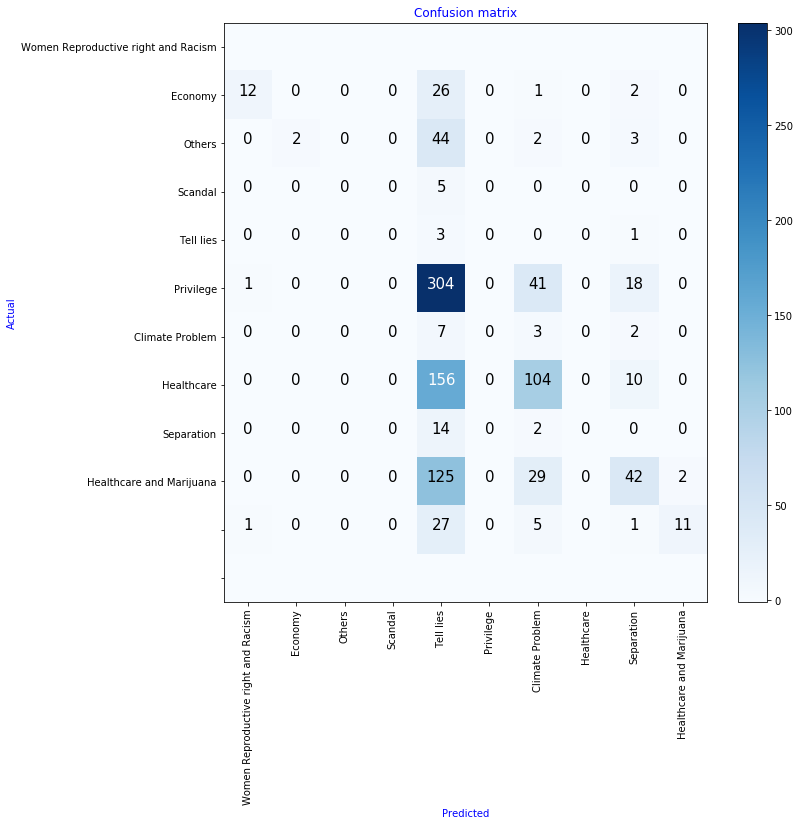

	 Accuracy : 47.22%
[[ 12   0   0   0  26   0   1   0   2   0]
 [  0   2   0   0  44   0   2   0   3   0]
 [  0   0   0   0   5   0   0   0   0   0]
 [  0   0   0   0   3   0   0   0   1   0]
 [  1   0   0   0 304   0  41   0  18   0]
 [  0   0   0   0   7   0   3   0   2   0]
 [  0   0   0   0 156   0 104   0  10   0]
 [  0   0   0   0  14   0   2   0   0   0]
 [  0   0   0   0 125   0  29   0  42   2]
 [  1   0   0   0  27   0   5   0   1  11]]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


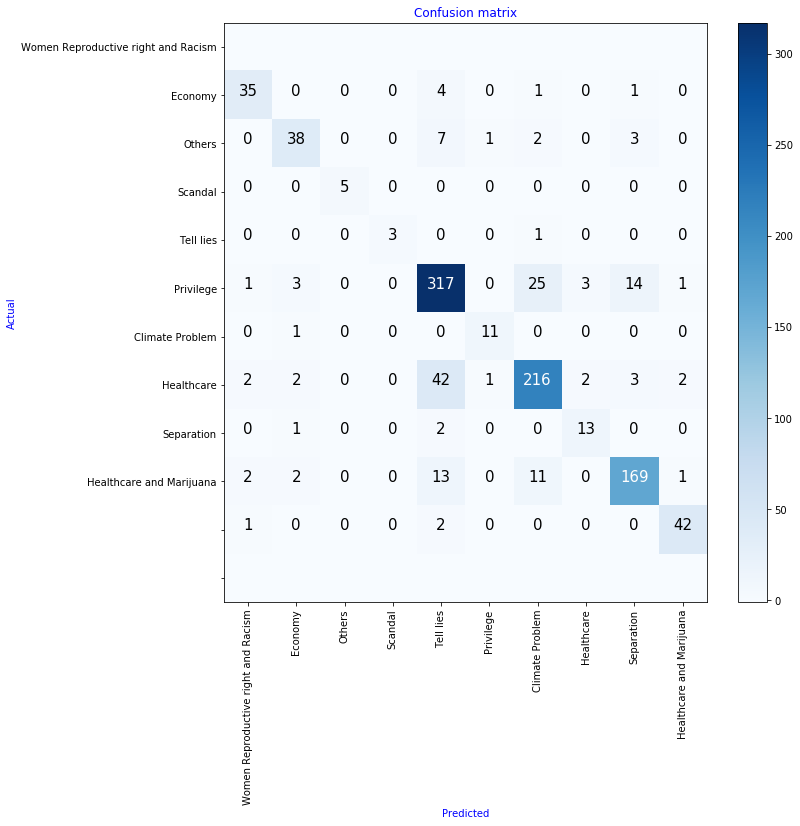

	 Accuracy : 84.39%
[[ 35   0   0   0   4   0   1   0   1   0]
 [  0  38   0   0   7   1   2   0   3   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   3   0   0   1   0   0   0]
 [  1   3   0   0 317   0  25   3  14   1]
 [  0   1   0   0   0  11   0   0   0   0]
 [  2   2   0   0  42   1 216   2   3   2]
 [  0   1   0   0   2   0   0  13   0   0]
 [  2   2   0   0  13   0  11   0 169   1]
 [  1   0   0   0   2   0   0   0   0  42]]
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random

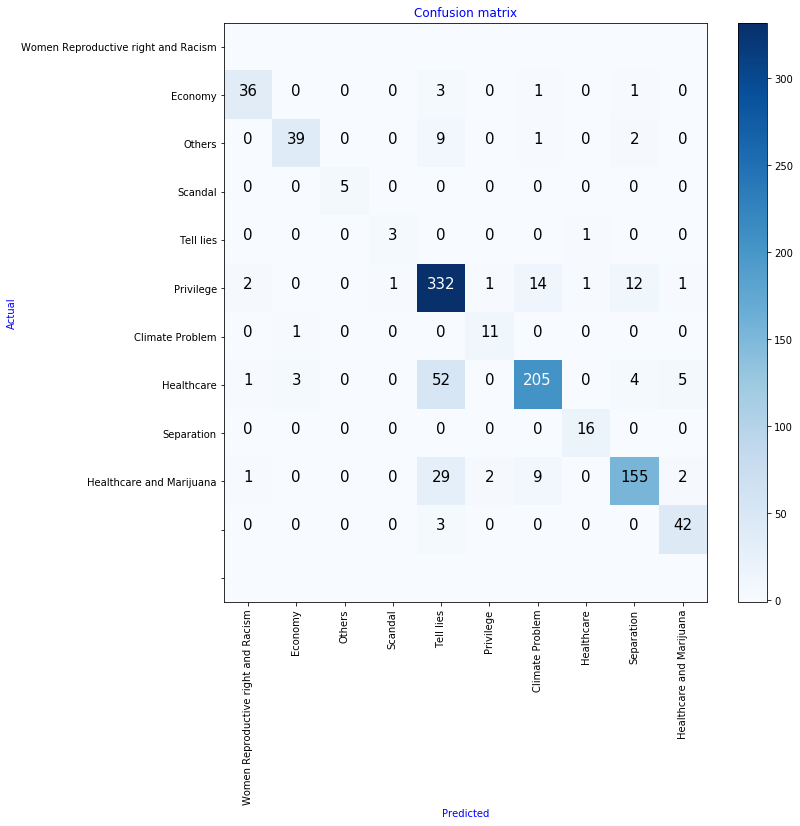

	 Accuracy : 83.9%
[[ 36   0   0   0   3   0   1   0   1   0]
 [  0  39   0   0   9   0   1   0   2   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   3   0   0   0   1   0   0]
 [  2   0   0   1 332   1  14   1  12   1]
 [  0   1   0   0   0  11   0   0   0   0]
 [  1   3   0   0  52   0 205   0   4   5]
 [  0   0   0   0   0   0   0  16   0   0]
 [  1   0   0   0  29   2   9   0 155   2]
 [  0   0   0   0   3   0   0   0   0  42]]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


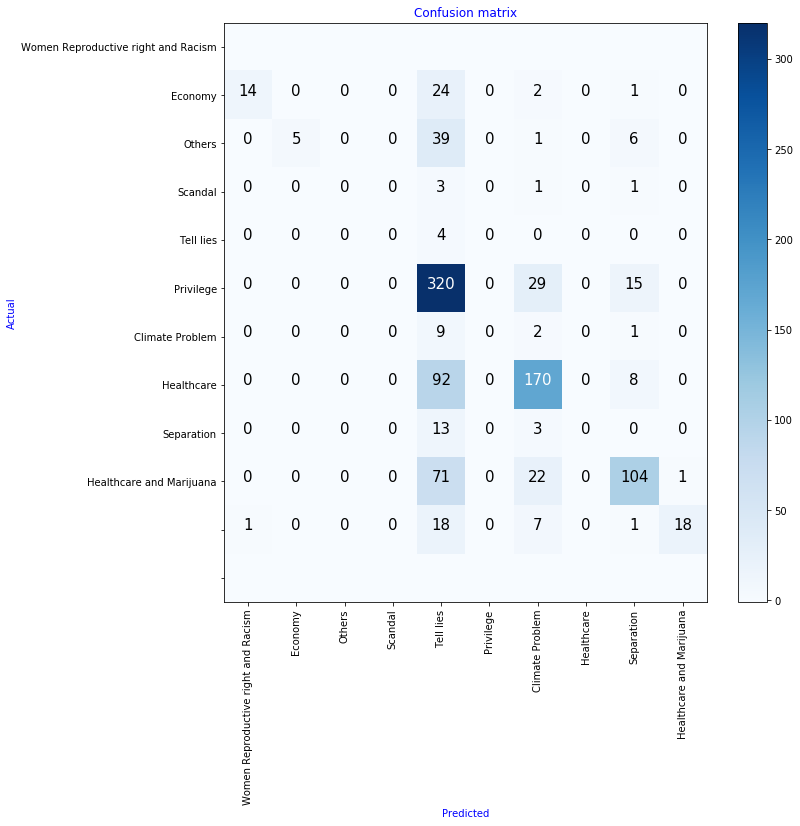

	 Accuracy : 62.72%
[[ 14   0   0   0  24   0   2   0   1   0]
 [  0   5   0   0  39   0   1   0   6   0]
 [  0   0   0   0   3   0   1   0   1   0]
 [  0   0   0   0   4   0   0   0   0   0]
 [  0   0   0   0 320   0  29   0  15   0]
 [  0   0   0   0   9   0   2   0   1   0]
 [  0   0   0   0  92   0 170   0   8   0]
 [  0   0   0   0  13   0   3   0   0   0]
 [  0   0   0   0  71   0  22   0 104   1]
 [  1   0   0   0  18   0   7   0   1  18]]
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.8, max_features=2000, min_df=5,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['a', 'able', 'about', 'above', 'abst', 'accordance',
                            'according', 'accordingly', 'across', 'act',
                            'actually', 'added', 'adj', 'affected', 'affecting',
                            'affects

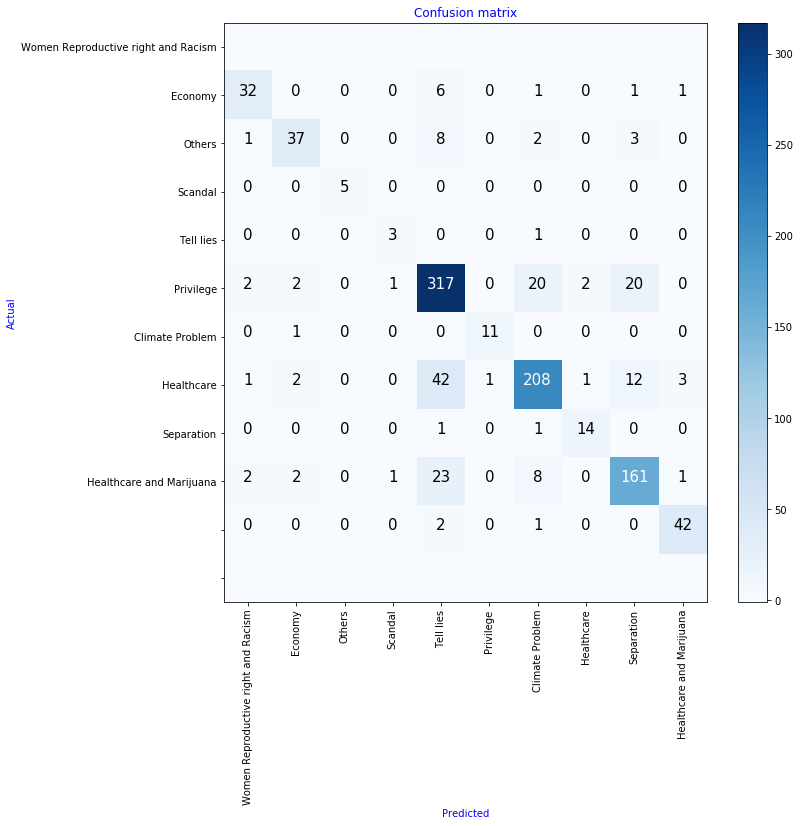

	 Accuracy : 82.5%
[[ 32   0   0   0   6   0   1   0   1   1]
 [  1  37   0   0   8   0   2   0   3   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   3   0   0   1   0   0   0]
 [  2   2   0   1 317   0  20   2  20   0]
 [  0   1   0   0   0  11   0   0   0   0]
 [  1   2   0   0  42   1 208   1  12   3]
 [  0   0   0   0   1   0   1  14   0   0]
 [  2   2   0   1  23   0   8   0 161   1]
 [  0   0   0   0   2   0   1   0   0  42]]
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


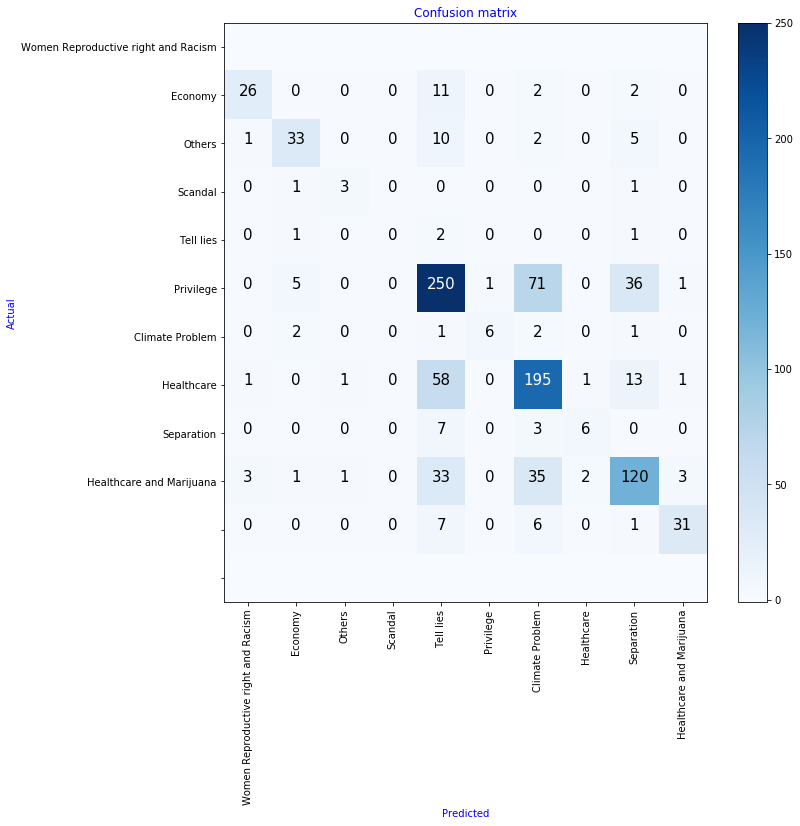

	 Accuracy : 66.6%
[[ 26   0   0   0  11   0   2   0   2   0]
 [  1  33   0   0  10   0   2   0   5   0]
 [  0   1   3   0   0   0   0   0   1   0]
 [  0   1   0   0   2   0   0   0   1   0]
 [  0   5   0   0 250   1  71   0  36   1]
 [  0   2   0   0   1   6   2   0   1   0]
 [  1   0   1   0  58   0 195   1  13   1]
 [  0   0   0   0   7   0   3   6   0   0]
 [  3   1   1   0  33   0  35   2 120   3]
 [  0   0   0   0   7   0   6   0   1  31]]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


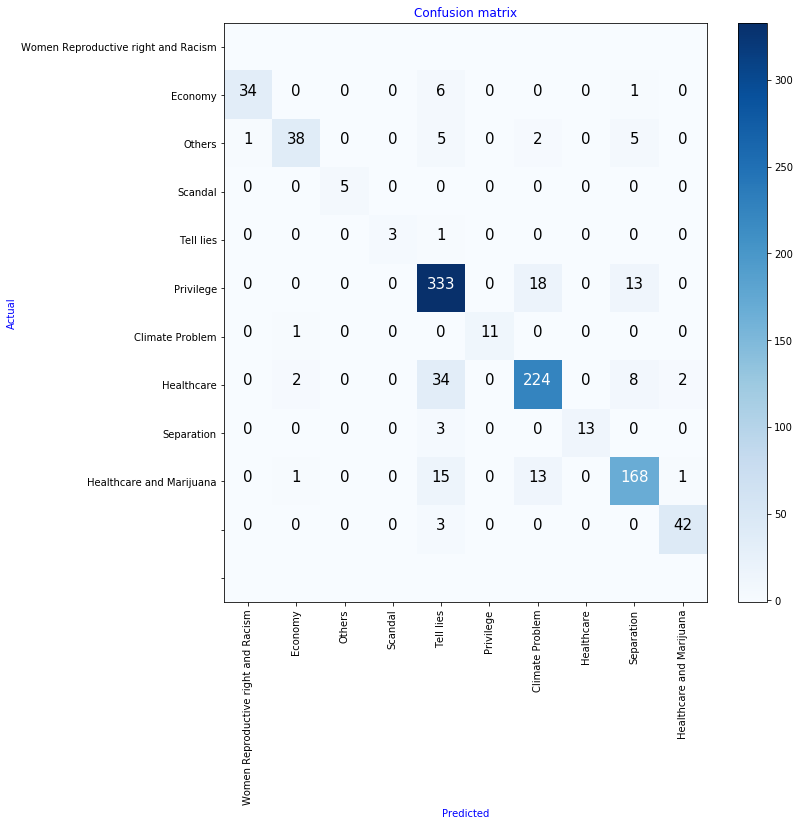

	 Accuracy : 86.58%
[[ 34   0   0   0   6   0   0   0   1   0]
 [  1  38   0   0   5   0   2   0   5   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   3   1   0   0   0   0   0]
 [  0   0   0   0 333   0  18   0  13   0]
 [  0   1   0   0   0  11   0   0   0   0]
 [  0   2   0   0  34   0 224   0   8   2]
 [  0   0   0   0   3   0   0  13   0   0]
 [  0   1   0   0  15   0  13   0 168   1]
 [  0   0   0   0   3   0   0   0   0  42]]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


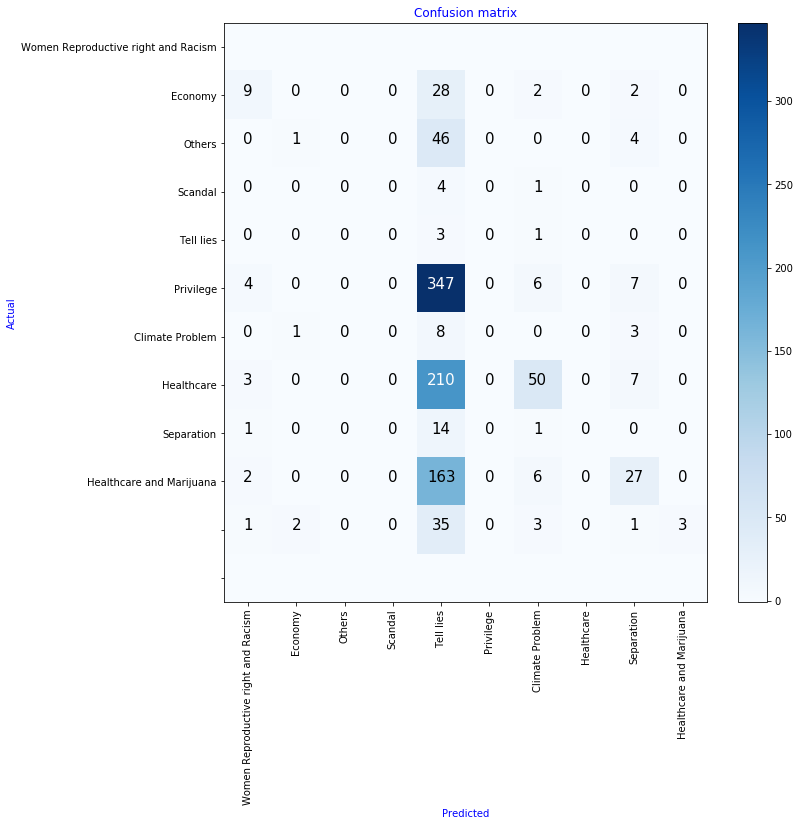

	 Accuracy : 43.44%
[[  9   0   0   0  28   0   2   0   2   0]
 [  0   1   0   0  46   0   0   0   4   0]
 [  0   0   0   0   4   0   1   0   0   0]
 [  0   0   0   0   3   0   1   0   0   0]
 [  4   0   0   0 347   0   6   0   7   0]
 [  0   1   0   0   8   0   0   0   3   0]
 [  3   0   0   0 210   0  50   0   7   0]
 [  1   0   0   0  14   0   1   0   0   0]
 [  2   0   0   0 163   0   6   0  27   0]
 [  1   2   0   0  35   0   3   0   1   3]]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')


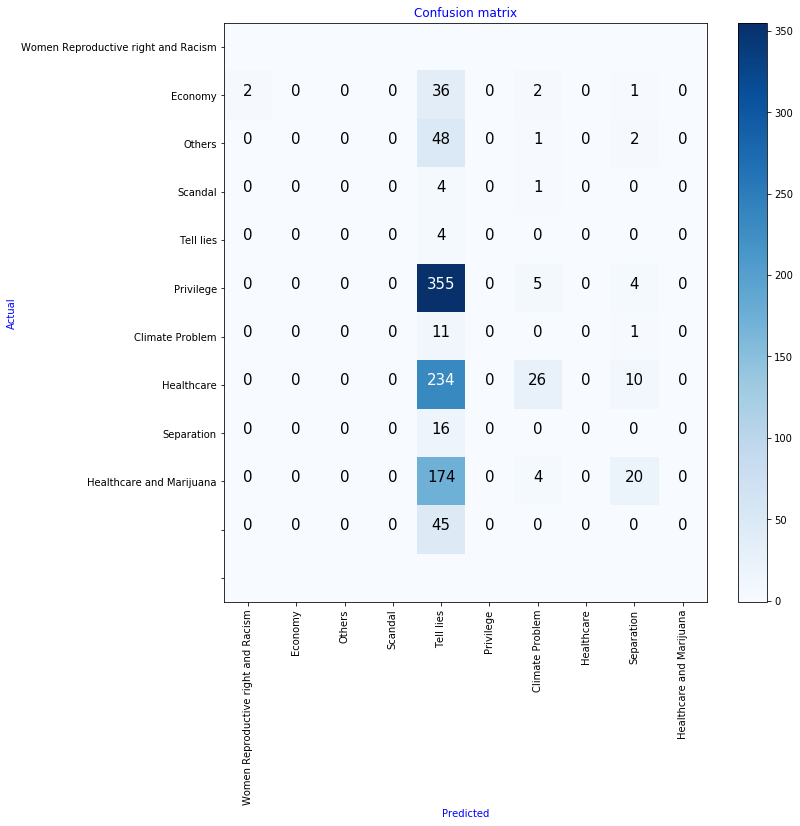

	 Accuracy : 40.06%
[[  2   0   0   0  36   0   2   0   1   0]
 [  0   0   0   0  48   0   1   0   2   0]
 [  0   0   0   0   4   0   1   0   0   0]
 [  0   0   0   0   4   0   0   0   0   0]
 [  0   0   0   0 355   0   5   0   4   0]
 [  0   0   0   0  11   0   0   0   1   0]
 [  0   0   0   0 234   0  26   0  10   0]
 [  0   0   0   0  16   0   0   0   0   0]
 [  0   0   0   0 174   0   4   0  20   0]
 [  0   0   0   0  45   0   0   0   0   0]]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')


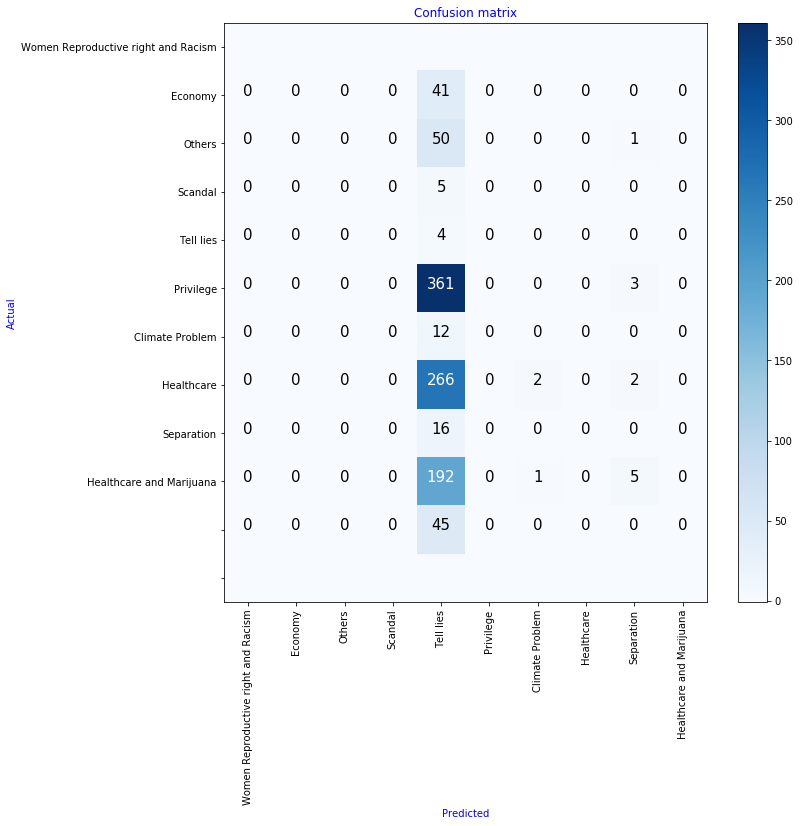

	 Accuracy : 36.58%
[[  0   0   0   0  41   0   0   0   0   0]
 [  0   0   0   0  50   0   0   0   1   0]
 [  0   0   0   0   5   0   0   0   0   0]
 [  0   0   0   0   4   0   0   0   0   0]
 [  0   0   0   0 361   0   0   0   3   0]
 [  0   0   0   0  12   0   0   0   0   0]
 [  0   0   0   0 266   0   2   0   2   0]
 [  0   0   0   0  16   0   0   0   0   0]
 [  0   0   0   0 192   0   1   0   5   0]
 [  0   0   0   0  45   0   0   0   0   0]]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


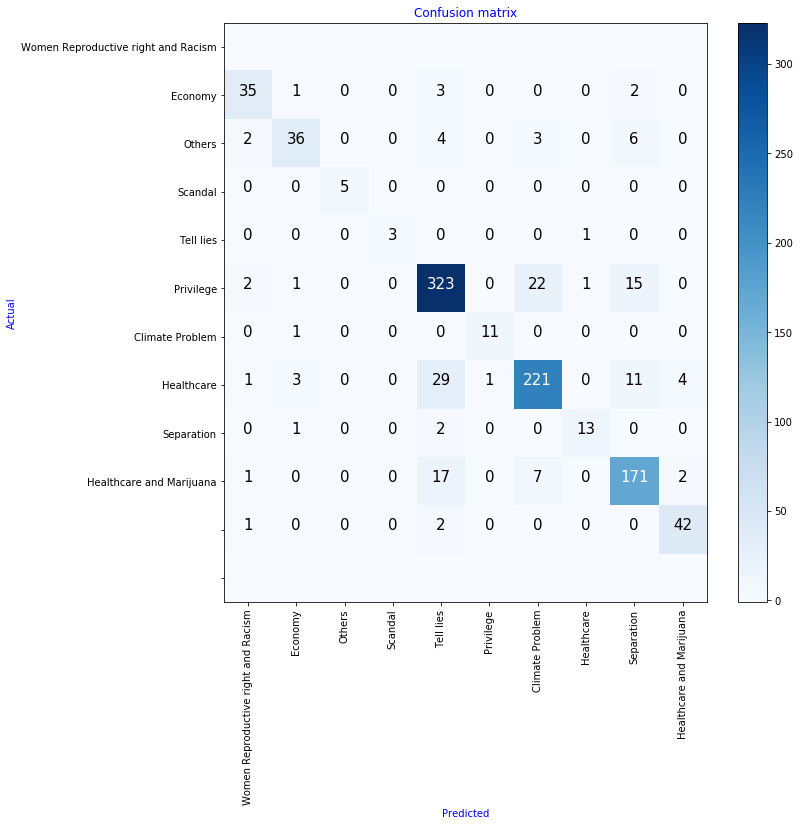

	 Accuracy : 85.49%
[[ 35   1   0   0   3   0   0   0   2   0]
 [  2  36   0   0   4   0   3   0   6   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   3   0   0   0   1   0   0]
 [  2   1   0   0 323   0  22   1  15   0]
 [  0   1   0   0   0  11   0   0   0   0]
 [  1   3   0   0  29   1 221   0  11   4]
 [  0   1   0   0   2   0   0  13   0   0]
 [  1   0   0   0  17   0   7   0 171   2]
 [  1   0   0   0   2   0   0   0   0  42]]
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random

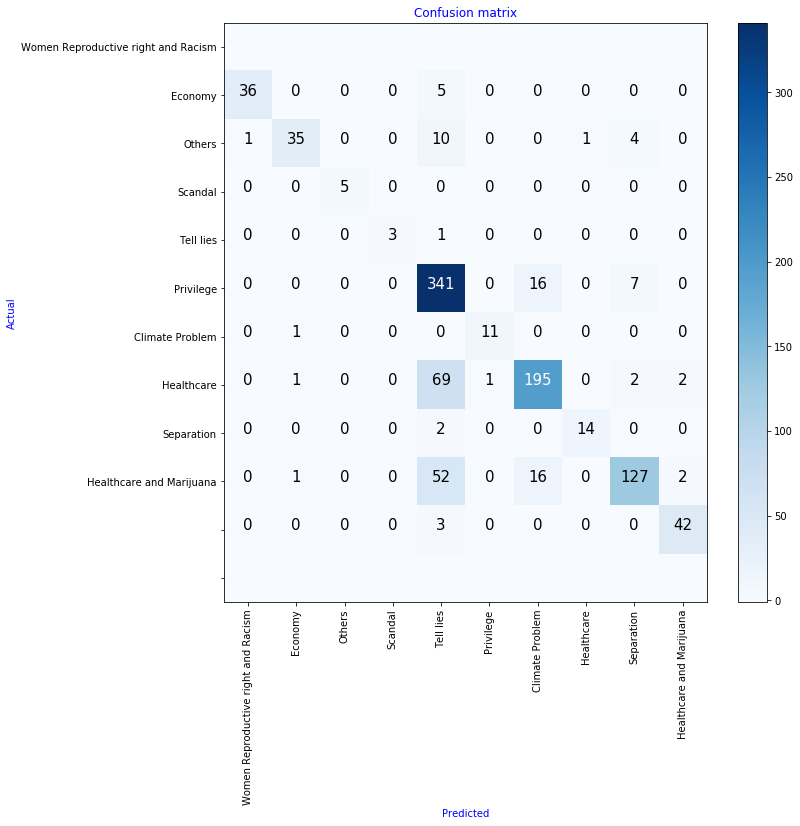

	 Accuracy : 80.42%
[[ 36   0   0   0   5   0   0   0   0   0]
 [  1  35   0   0  10   0   0   1   4   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   3   1   0   0   0   0   0]
 [  0   0   0   0 341   0  16   0   7   0]
 [  0   1   0   0   0  11   0   0   0   0]
 [  0   1   0   0  69   1 195   0   2   2]
 [  0   0   0   0   2   0   0  14   0   0]
 [  0   1   0   0  52   0  16   0 127   2]
 [  0   0   0   0   3   0   0   0   0  42]]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


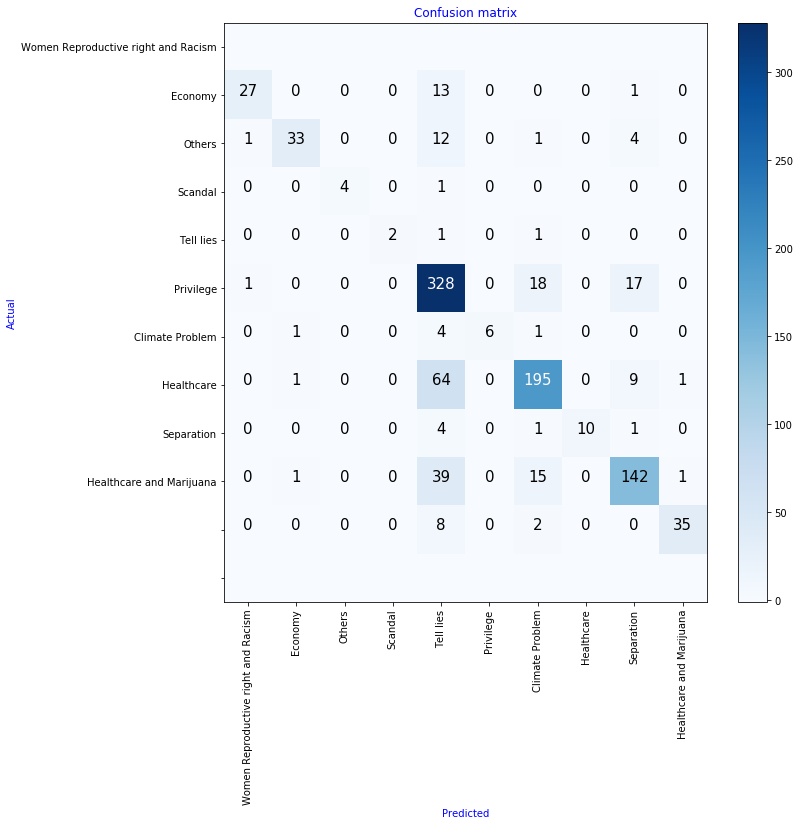

	 Accuracy : 77.73%
[[ 27   0   0   0  13   0   0   0   1   0]
 [  1  33   0   0  12   0   1   0   4   0]
 [  0   0   4   0   1   0   0   0   0   0]
 [  0   0   0   2   1   0   1   0   0   0]
 [  1   0   0   0 328   0  18   0  17   0]
 [  0   1   0   0   4   6   1   0   0   0]
 [  0   1   0   0  64   0 195   0   9   1]
 [  0   0   0   0   4   0   1  10   1   0]
 [  0   1   0   0  39   0  15   0 142   1]
 [  0   0   0   0   8   0   2   0   0  35]]


In [23]:
confMatrix    = np.zeros((10,10));  # Confusion matrix
best_accuracy = 0 

# run each vectorizer with each classifier
for vectorizer in   listOfVectorizers:  
    print (vectorizer)
    
    # prepare the vectors from the tweets
    train_corpus_ = vectorizer.fit_transform(X_train)
    test_corpus_  = vectorizer.transform(X)
    
    for classifier in listOfClassifiers:
        print(classifier)
        
        model      =  classifier
        
        # fit the model with the training data
        model.fit(train_corpus_,y_train)
        
        # check the accuracy with the test data
        result     = model.predict(test_corpus_)
        confMatrix = confusion_matrix(y, result)
         
        class_names = y.unique()
        padd_plot_conf_matrix(confMatrix, class_names, class_names)

        total      = sum(y == result)
        accuracy   = round (100*total/y.shape[0], 2)
        print ('\t Accuracy : ' +   str (accuracy) + '%')
        print(confMatrix)
        if accuracy > best_accuracy:
            best_accuracy   = accuracy
            best_classifier = model
            best_vectorizer = vectorizer
         

In [24]:
print (' Best Accuracy: ' +  str (best_accuracy) + '%')
print (' Best Model: ' + str(best_classifier))
print (' Best Vectorizer: '  + str(best_vectorizer))

 Best Accuracy: 87.38%
 Best Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
 Best Vectorizer: TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=2000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'able', 'about', 'above', 'abst', 'accorda

The accuracy ranges from 36% to 86%. The best classifer is the RandomForest and had an accuracy of 86%. To improve the accuracy I noticed from the confusion matrix that lots of the records with Scandal reason were classified as Other. Consequently, I chose to merge the 'Scandal' and 'Other' and re-run the classifier.

In [25]:
y [y == 'Scandal'] = 'Others'
X_train, X_test, y_train, y_test = train_test_split(neg_sent_df['processed_tweet'], y, random_state=0, test_size=0.3)

X = neg_sent_df['processed_tweet']

In [26]:
confMatrix    = np.zeros((10,10));  # Confusion matrix
best_accuracy = 0 
for vectorizer in   listOfVectorizers:  
    print (vectorizer)
    train_corpus_ = vectorizer.fit_transform(X_train)
    test_corpus_  = vectorizer.transform(X_test)
    whole_corpus_ = vectorizer.transform(X)
    
    for classifier in listOfClassifiers:
        print(classifier)

        model      =  classifier
        
        model.fit(train_corpus_,y_train)
        
        result     = model.predict(whole_corpus_)
        confMatrix = confusion_matrix(y, result)
        total      = sum(y == result)
        accuracy   = round (100*total/y.shape[0], 2)
        print ('\t Accuracy : ' +   str (accuracy) + '%')
        print(confMatrix)
        if accuracy > best_accuracy:
            best_accuracy   = accuracy
            best_classifier = model
            best_vectorizer = vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=2000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'able', 'about', 'above', 'abst', 'accordance',
                            'according', 'accordingly', 'across', 'act',
                            'actually', 'added', 'adj', 'affected', 'affecting',
                            'affects', 'after', 'afterwards', 'again',
                            'against', 'ah', 'all', 'almost', 'alone', 'along',
                            'already', 'also', 'although', 'always', 'am', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)
LinearSVC(C=1.0, class_weight=None, dua

#### Best model after the merging of 2 values

In [28]:
print (' Best Accuracy: ' +  str (best_accuracy) + '%')
print (' Best Model: ' + str(best_classifier))
print (' Best Vectorizer: '  + str(best_vectorizer))

 Best Accuracy: 93.24%
 Best Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
 Best Vectorizer: TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=2000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'able', 'about', 'above', 'abst', 'accorda

As evidenced above, after merging the two values the range of the accuracy for the classifiers went from 36-86%  to 63-93%. Subsequently, the best accuracy is 93% for the RandomForest Classifier with the TFID vectorizer.

## Results

### Party Identification
This is a prediction problem but without knowing the real result. The approach used (keyword matching) is a very naive/simplified approach. In addition, because I don't have the right answers I do not know how many of the results are correct. This is an example of the problem with unsupervised learning. One way to improve the results would be to add an extra column on the tweet that would indicate the political party. This way I can apply classifiers, supervised learning and do machine learning. Another way to improve the results is to read individual tweets and try to expand the keywords matching for each political party. 


### Sentiment Prediction
The best model was the Logistic Regression and the accuracy was around 72%. The accuracy could have been higher if I had used the test and the training data to calculate the accuracy. Another way to improve the accuracy would had been if I could use more words or if our stop words list was smaller. I looked at the stop words and i thought that some of the stop words used may had some significant meaning for example (alone, affected, available,etc.) Maybe if I had used fewer and/or more selective stop words the accuracy could had been better. Another approach would be if I had used neural networks. I tried one model but it was very slow and the performance was similar to the classifiers I used. Consequently, if I had access to more powerful computation machines I could had tried different neural network models which may have imporved the results.  

### Negative Reason Prediction
The accuracy of the best model was 86% without any changes. The best model was the Random Forest classifier. Then, after I merged the 2 values the accuracy improved to around 93%. One improvement would be if there was more data since the Canadian Elections file has only 2000 records. Another way would be if I merged more values but this is circumventing the reason for the machine learning. Moreover, as I increase the number of merged values I also loose more values in the prediction. One solution to this would be if I create a second classifier that separates  the merged value where the first classifier predicts the value that is merged. Finally, one reason for the high accuracy is because the values are very skewed and the 2 values I merged account for more than half of all the records.


### Party percentages prediction
The approach I took to predict the party and predict the sentiment for each tweet resulted in the following results: 

1. Liberal percentage = 38.28
2. Conservative percentage = 36.33
3. NDP percentage = 33.33
<br>
<br>

The percentages for the Liberals and the Conservatives are very close to the real election percentages, as illustrated in the following: 
1. Liberal percentage: 33
2. Conservative percentage: 34.4 
3. NDP percentage: 15.9 
<br>
<br>

In conclusion, the Liberals and Conservatives were within <5 percentage points of the real election percentages. The NDP was off by a little over 15%. Finally, this part contained the same issues with the party identification. There is a limitation since I can't train a classifier to identify the party because I don't have the real party for each tweet. 